In [75]:
from numpy.random import seed
import tensorflow as tf
seed(1)
tf.random.set_seed(2)

### Naive Bayes

In [76]:
import pandas as pd
import numpy as np
from sklearn.utils import resample
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

#import dataset
df_preprocess = pd.read_csv('/content/drive/MyDrive/Master/length_trim_sequences.csv', converters={'sequence_events': eval})
# convert target labels to [0,1]
df_preprocess['target_label'] = np.array(df_preprocess['target_label'].replace(to_replace={"A" : 0, "P" : 1}))

In [77]:
def vectorize(data, voc):
  sequences = data.iloc[:, 1]
  # create corpus of all sequences in dataset
  corpus = []
  for seq in sequences:
    seqstr = ''.join([str(item) for item in seq])
    corpus.append(seqstr)
  
  # Tf-idf will be used to get a normalized frequency count of all 5-grams in the corpus. More interesting 5-grams are basically given a higher weight
  vectorizer = TfidfVectorizer(ngram_range=(5,5), analyzer='char', vocabulary=voc)
  #tokenizing sequences, i.e. give id to each possible n-gram
  X = vectorizer.fit_transform(corpus)
  # target labels for sequences
  Y = data.iloc[:, 2]
  return X, Y, vectorizer

In [78]:
X, Y, vectorize_all = vectorize(df_preprocess, None)
#all possible 5-grams present in sequences dataset, also counts 5-gram occurences in corpus
vocab = vectorize_all.get_feature_names()

In [79]:
#split dataset into 0.9 train and 0.1 test
train, validation = train_test_split(df_preprocess, test_size=0.1, random_state=42, stratify=df_preprocess['target_label'])

In [80]:
#vectorization of sequences
#use vocab of whole corpus to vectorize the train set
X_train_NB, Y_train_NB, vectorizer_train = vectorize(train, vocab)

# use same vocab to vectorize val_set
X_val_NB, Y_val_NB, vectorizer_val = vectorize(validation, vocab)

#array with the count of each 5-gram occurence per sequence in corpus, each vector/row represents 1 sequence in corpus, each column a unique 5-gram/feature
print(X_train_NB.toarray())

[[0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.67771133 0.16760809 0.         ... 0.         0.         0.        ]]


In [81]:
print(X_train_NB.shape)
print(Y_train_NB.shape)
print(X_val_NB.shape)
print(Y_val_NB.shape)

(33344, 1074)
(33344,)
(3705, 1074)
(3705,)


In [82]:
# NB model implementation
from sklearn.naive_bayes import MultinomialNB

model = MultinomialNB()

model.fit(X_train_NB, Y_train_NB)
predicted_labels = model.predict(X_val_NB)

In [83]:
from sklearn.metrics import classification_report

print(classification_report(Y_val_NB, predicted_labels, digits=4))

              precision    recall  f1-score   support

           0     0.8405    0.9495    0.8917      3008
           1     0.5049    0.2224    0.3088       697

    accuracy                         0.8127      3705
   macro avg     0.6727    0.5859    0.6002      3705
weighted avg     0.7774    0.8127    0.7820      3705



In [84]:
from sklearn.model_selection import cross_val_score

model = MultinomialNB()
scores = cross_val_score(model, X_train_NB, Y_train_NB, cv = 10, scoring='f1_weighted')
print(scores)

[0.77292554 0.77437095 0.77689504 0.77724276 0.77544499 0.76642407
 0.78988126 0.77166047 0.77774841 0.77774535]


In [85]:
print('Average cross-validation score: {:.4f}'.format(scores.mean()))

Average cross-validation score: 0.7760


In [86]:
from sklearn.metrics import confusion_matrix

tn, fp, fn, tp = confusion_matrix(Y_val_NB, predicted_labels).ravel()
print(tn, fp, fn, tp)
confusion_matrix(Y_val_NB, predicted_labels)

2856 152 542 155


array([[2856,  152],
       [ 542,  155]])

In [87]:
  # AUC NB_imbalanced
from sklearn.metrics import roc_auc_score

auc = roc_auc_score(Y_val_NB, predicted_labels)
print(auc)

0.5859248603437224


### LSTMs

In [88]:
import pandas as pd
import numpy as np
import keras
from sklearn.utils import resample
from keras.preprocessing import sequence
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split

#import dataset
df_preprocess = pd.read_csv('/content/drive/MyDrive/Master/length_trim_sequences.csv', converters={'sequence_events': eval})

def OneHot(data):
  X = data.iloc[:, 1]
  Y = data.iloc[:, 2]
    #create array of arrays of sequence lists as models needs arrays as input data type
  X_arr = np.array([np.array(seq) for seq in X])

    #transform labels to integers for input model
  Y = np.array(Y.replace(to_replace={"A" : 0, "P" : 1}))

    #add Start/End symbols, 7 = Start symbol, 8 = End symbol
  X_SE = [np.insert(seq, [0], '7') for seq in X_arr] # add '7' before first browsing event
  X_SE = [np.append(seq, '8') for seq in X_SE] # add '8' to end of event sequence

    #add padding to sequences, Padding value = 0
    #each column represents 1 timestamp in the event sequence, values are transformed to integers instead of strings
  X_padding = sequence.pad_sequences(X_SE, maxlen=157, padding= 'post', value=0) # also changes dimension 1D -> 2D (37049, 157)

  # binary encode
  enc = OneHotEncoder(sparse=False, handle_unknown='ignore') #initialize One-Hot-Encoder
  reshape = np.array([seq.reshape(len(X_padding[0]), 1) for seq in X_padding]) #reshape each sequence in set from 1D array to 2D arrays
  categories = np.reshape([1,2,3,4,5,7,8], (-1,1)) # all possible categories, also reshaped from 1D to 2D

  enc.fit(categories) # fit Encoder to determine category for the input feature

  X_oneHot = np.array([enc.transform(seq) for seq in reshape]) # transforms input data to 3D tensor (37049, 157, 7)
  ## 7 features, including BOS, EOS, so (37049, 157, 7), padding rows will be just a row of zeros
  return X_oneHot, Y


In [89]:
X, Y = OneHot(df_preprocess)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  app.launch_new_instance()


In [90]:
#split dataset into 0.8 train, 0.1 validation and 0.1 test
X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.2, random_state=42, stratify=Y)
X_val, X_test, Y_val, Y_test = train_test_split(X_val, Y_val, test_size=0.5, random_state=42, stratify=Y_val)

In [91]:
print(X_train.shape)
print(Y_train.shape)
print(X_val.shape)
print(Y_val.shape)
print(X_test.shape)
print(Y_test.shape)

(29639, 157, 7)
(29639,)
(3705, 157, 7)
(3705,)
(3705, 157, 7)
(3705,)


In [ ]:
# gridsearch
import numpy
from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasClassifier

import tensorflow as tf
from numpy.random import seed
seed(1)
tf.random.set_seed(2)

import keras
from keras.layers import Dense, LSTM, Masking, Input, BatchNormalization
from keras import Model
from tensorflow.keras.callbacks import EarlyStopping

def create_model(neurons = 16):
  inputs = Input(shape=(157, 7), name='main_input')
  mask = Masking(mask_value = [0.,0.,0.,0.,0.,0.,0.], name='mask')(inputs)
  #LSTM Layer
  lstm3 = LSTM(neurons)(mask)
  batchnorm = BatchNormalization()(lstm3)

  #output layer
  dense_layer = Dense(1, activation='sigmoid', name='dense_layer')(batchnorm)

  #Adam optimizer
  optimizer = keras.optimizers.Adam(learning_rate=0.001)
  model3 = Model(inputs=[inputs], outputs=[dense_layer])
  model3.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

  #early stopping
  es = EarlyStopping(monitor = 'val_loss', patience=10)
  return model3

model3 = KerasClassifier(build_fn=create_model, verbose=1)

neurons = [16, 32, 64]
batch_size = [16, 32, 64]
epochs = [50]
param_grid = dict(batch_size=batch_size, epochs=epochs, neurons=neurons)
grid = GridSearchCV(estimator=model3, param_grid=param_grid, cv=3, verbose=3)
grid_result = grid.fit(X_train, Y_train)

#summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

### Last LSTM

In [101]:
from numpy.random import seed
seed(1)
tf.random.set_seed(2)

from keras import layers
from keras.models import Sequential
from keras.layers import Dense, LSTM, Masking, Input, BatchNormalization
from keras import Model
from tensorflow.keras.callbacks import EarlyStopping

inputs = Input(shape=(157, 7), name='main_input')
mask = Masking(mask_value = [0.,0.,0.,0.,0.,0.,0.], name='mask')(inputs)
#LSTM Layer
lstm3 = LSTM(32)(mask)
batchnorm = BatchNormalization()(lstm3)

#output layer
dense_layer = Dense(1, activation='sigmoid', name='dense_layer')(batchnorm)

#Adam optimizer
optimizer = keras.optimizers.Adam(learning_rate=0.001)
model3 = Model(inputs=[inputs], outputs=[dense_layer])
model3.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

#early stopping
es = EarlyStopping(monitor = 'val_loss', patience=10)

model3.summary()

Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
main_input (InputLayer)      [(None, 157, 7)]          0         
_________________________________________________________________
mask (Masking)               (None, 157, 7)            0         
_________________________________________________________________
lstm_5 (LSTM)                (None, 32)                5120      
_________________________________________________________________
batch_normalization_5 (Batch (None, 32)                128       
_________________________________________________________________
dense_layer (Dense)          (None, 1)                 33        
Total params: 5,281
Trainable params: 5,217
Non-trainable params: 64
_________________________________________________________________


In [102]:
third_model = model3.fit(X_train, Y_train, epochs=50, batch_size = 16, validation_data=(X_val, Y_val), verbose = 1, callbacks=[es])
model3.save('/LastLSTM.h5')

Epoch 1/50
1853/1853 [==============================] - 48s 24ms/step - loss: 0.3752 - accuracy: 0.8139 - val_loss: 0.2822 - val_accuracy: 0.8540
Epoch 2/50
1853/1853 [==============================] - 42s 23ms/step - loss: 0.2913 - accuracy: 0.8417 - val_loss: 0.3249 - val_accuracy: 0.8213
Epoch 3/50
1853/1853 [==============================] - 43s 23ms/step - loss: 0.2859 - accuracy: 0.8455 - val_loss: 0.2738 - val_accuracy: 0.8564
Epoch 4/50
1853/1853 [==============================] - 43s 23ms/step - loss: 0.2728 - accuracy: 0.8528 - val_loss: 0.2776 - val_accuracy: 0.8467
Epoch 5/50
1853/1853 [==============================] - 43s 23ms/step - loss: 0.2845 - accuracy: 0.8478 - val_loss: 0.2798 - val_accuracy: 0.8534
Epoch 6/50
1853/1853 [==============================] - 43s 23ms/step - loss: 0.2840 - accuracy: 0.8479 - val_loss: 0.2722 - val_accuracy: 0.8583
Epoch 7/50
1853/1853 [==============================] - 43s 23ms/step - loss: 0.2741 - accuracy: 0.8542 - val_loss: 0.2699 -

In [119]:
#metrics lastState LSTM

pred_last_prob = model3.predict(X_test)
pred_last_class = np.round(pred_last_prob)

print(np.unique(pred_last_class, return_counts=True))
print(np.unique(Y_test, return_counts=True))

(array([0., 1.], dtype=float32), array([2866,  839]))
(array([0, 1]), array([3008,  697]))


In [120]:
from sklearn.metrics import classification_report

print(classification_report(Y_test, pred_last_class, digits=4))

              precision    recall  f1-score   support

           0     0.9330    0.8890    0.9105      3008
           1     0.6019    0.7245    0.6576       697

    accuracy                         0.8580      3705
   macro avg     0.7675    0.8067    0.7840      3705
weighted avg     0.8707    0.8580    0.8629      3705



In [105]:
from sklearn.metrics import confusion_matrix

tn, fp, fn, tp = confusion_matrix(Y_test, pred_last_class).ravel()
print(tn, fp, fn, tp)
confusion_matrix(Y_test, pred_last_class)

2674 334 192 505


array([[2674,  334],
       [ 192,  505]])

In [106]:
  # AUC lastLSTM
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

auc_last = roc_auc_score(Y_test, pred_last_prob)
print(auc_last)

0.926269546155255


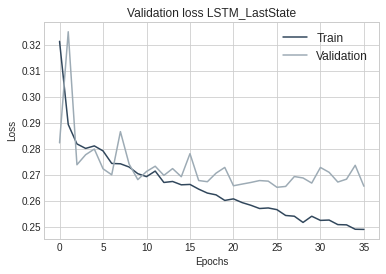

In [107]:
import matplotlib.pyplot as plt
loss = plt.style.use('seaborn-whitegrid')
loss = plt.plot(third_model.history['loss'], color = "#31475C")
loss = plt.plot(third_model.history['val_loss'], color = "#9DABB5")
loss = plt.title('Validation loss LSTM_LastState')
loss = plt.ylabel('Loss')
loss = plt.xlabel('Epochs')
loss = plt.legend(['Train', 'Validation'], loc = 'upper right', fontsize = 12)
loss = plt.savefig('LSTM_loss_last.png')
loss = plt.show()

In [108]:
score, acc = model3.evaluate(X_test, Y_test)

print('Loss function:', score)
print('Test accuracy:', acc)

116/116 [==============================] - 1s 11ms/step - loss: 0.2536 - accuracy: 0.8580
Loss function: 0.2536024749279022
Test accuracy: 0.8580296635627747


### Average LSTM

In [ ]:
# gridsearch
import numpy
from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasClassifier

import tensorflow as tf
from numpy.random import seed
seed(1)
tf.random.set_seed(2)

import keras
from keras.layers import Dense, LSTM, Masking, Input, BatchNormalization
from keras import Model
from tensorflow.keras.callbacks import EarlyStopping

def create_model(neurons = 16):
  inputs = Input(shape=(157, 7), name='main_input')
  mask = Masking(mask_value = [0.,0.,0.,0.,0.,0.,0.], name='mask')(inputs)
  #LSTM Layer
  lstm4 = LSTM(64, return_sequences=True)(mask)
  batchnorm = BatchNormalization()(lstm4)

  Gpooling = GlobalAveragePooling1D()(batchnorm)

  #output layer
  dense_layer = Dense(1, activation='sigmoid', name='dense_layer')(Gpooling)
  #Adam optimizer
  optimizer = keras.optimizers.Adam(learning_rate=0.001)
  model3 = Model(inputs=[inputs], outputs=[dense_layer])
  model3.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

  #early stopping
  es = EarlyStopping(monitor = 'val_loss', patience=10)
  return model3

model3 = KerasClassifier(build_fn=create_model, verbose=1)

neurons = [16, 32, 64]
batch_size = [16, 32, 64]
epochs = [50]
param_grid = dict(batch_size=batch_size, epochs=epochs, neurons=neurons)
grid = GridSearchCV(estimator=model3, param_grid=param_grid, cv=3, verbose=3)
grid_result = grid.fit(X_train, Y_train)

#summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

In [109]:
from numpy.random import seed
seed(1)
tf.random.set_seed(2)

from keras import layers
from keras.models import Sequential
from keras.layers import Dense, LSTM, Masking, Input, BatchNormalization, GlobalAveragePooling1D
from keras import Model
from tensorflow.keras.callbacks import EarlyStopping

inputs = Input(shape=(157, 7), name='main_input')
mask = Masking(mask_value = [0.,0.,0.,0.,0.,0.,0.], name='mask')(inputs)
#LSTM Layer
lstm4 = LSTM(64, return_sequences=True)(mask)
batchnorm = BatchNormalization()(lstm4)

Gpooling = GlobalAveragePooling1D()(batchnorm)

#output layer
dense_layer = Dense(1, activation='sigmoid', name='dense_layer')(Gpooling)

#Adam optimizer
optimizer = keras.optimizers.Adam(learning_rate=0.001)
model4 = Model(inputs=[inputs], outputs=[dense_layer])
model4.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

#early stopping
es = EarlyStopping(monitor = 'val_loss', patience=10)

model4.summary()

Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
main_input (InputLayer)      [(None, 157, 7)]          0         
_________________________________________________________________
mask (Masking)               (None, 157, 7)            0         
_________________________________________________________________
lstm_6 (LSTM)                (None, 157, 64)           18432     
_________________________________________________________________
batch_normalization_6 (Batch (None, 157, 64)           256       
_________________________________________________________________
global_average_pooling1d (Gl (None, 64)                0         
_________________________________________________________________
dense_layer (Dense)          (None, 1)                 65        
Total params: 18,753
Trainable params: 18,625
Non-trainable params: 128
_____________________________________________________

In [110]:
fourth_model = model4.fit(X_train, Y_train, epochs=50, batch_size = 16, validation_data=(X_val, Y_val), verbose = 1, callbacks=[es])
model4.save('/avgLSTM_.h5')

Epoch 1/50
1853/1853 [==============================] - 55s 27ms/step - loss: 0.4198 - accuracy: 0.8114 - val_loss: 0.3540 - val_accuracy: 0.8283
Epoch 2/50
1853/1853 [==============================] - 50s 27ms/step - loss: 0.3159 - accuracy: 0.8391 - val_loss: 0.3666 - val_accuracy: 0.8232
Epoch 3/50
1853/1853 [==============================] - 49s 27ms/step - loss: 0.2963 - accuracy: 0.8462 - val_loss: 0.2901 - val_accuracy: 0.8491
Epoch 4/50
1853/1853 [==============================] - 49s 27ms/step - loss: 0.2786 - accuracy: 0.8538 - val_loss: 0.2881 - val_accuracy: 0.8505
Epoch 5/50
1853/1853 [==============================] - 49s 27ms/step - loss: 0.2825 - accuracy: 0.8498 - val_loss: 0.3072 - val_accuracy: 0.8356
Epoch 6/50
1853/1853 [==============================] - 49s 27ms/step - loss: 0.2797 - accuracy: 0.8519 - val_loss: 0.2765 - val_accuracy: 0.8507
Epoch 7/50
1853/1853 [==============================] - 50s 27ms/step - loss: 0.2714 - accuracy: 0.8596 - val_loss: 0.2741 -

In [121]:
#metrics averageState LSTM

pred_average_prob = model4.predict(X_test)
pred_average_class = np.round(pred_average_prob)

print(np.unique(pred_average_class, return_counts=True))
print(np.unique(Y_test, return_counts=True))

(array([0., 1.], dtype=float32), array([3064,  641]))
(array([0, 1]), array([3008,  697]))


In [122]:
from sklearn.metrics import classification_report

print(classification_report(Y_test, pred_average_class, digits=4))

              precision    recall  f1-score   support

           0     0.9099    0.9269    0.9183      3008
           1     0.6568    0.6040    0.6293       697

    accuracy                         0.8661      3705
   macro avg     0.7834    0.7654    0.7738      3705
weighted avg     0.8623    0.8661    0.8639      3705



In [113]:
  # AUC averageLSTM
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

auc_average = roc_auc_score(Y_test, pred_average_prob)
print(auc_average)

0.9245810788638237


In [114]:
from sklearn.metrics import confusion_matrix

tn, fp, fn, tp = confusion_matrix(Y_test, pred_average_class).ravel()
print(tn, fp, fn, tp)
confusion_matrix(Y_test, pred_average_class)

2788 220 276 421


array([[2788,  220],
       [ 276,  421]])

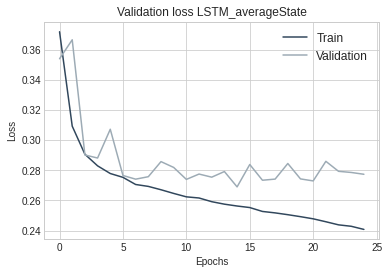

In [115]:
import matplotlib.pyplot as plt
loss = plt.style.use('seaborn-whitegrid')
loss = plt.plot(fourth_model.history['loss'], color = "#31475C")
loss = plt.plot(fourth_model.history['val_loss'], color = "#9DABB5")
loss = plt.title('Validation loss LSTM_averageState')
loss = plt.ylabel('Loss')
loss = plt.xlabel('Epochs')
loss = plt.legend(['Train', 'Validation'], loc = 'upper right', fontsize = 12)
loss = plt.savefig('LSTM_loss_avg.png')
loss = plt.show()

In [116]:
score, acc = model4.evaluate(X_test, Y_test)

print('Loss function:', score)
print('Test accuracy:', acc)

116/116 [==============================] - 1s 12ms/step - loss: 0.2623 - accuracy: 0.8661
Loss function: 0.26225629448890686
Test accuracy: 0.8661268353462219
